Imports

In [16]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os

Device

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Plot functions

In [18]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Class to manage configuration

In [19]:
class Config():
    training_dir = "images/training" #path to the training directory
    testing_dir =  "images/testing" #path to the testing directory
    train_batch_size = 64

Generates image pairs --> 0 for geniune pair and 1 for imposter pair

In [20]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [21]:
folder_dataset = dset.ImageFolder(root=Config.training_dir) #training dataset


Custom datasets

In [22]:
siamese_dataset_128x128_2 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

siamese_dataset_32x32_2 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((32,32)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)


Train dataloaders

In [23]:
train_dataloader_128x128_2 = DataLoader(siamese_dataset_128x128_2,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

train_dataloader_32x32_2 = DataLoader(siamese_dataset_32x32_2,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

Visualization image pairs --> 1 indiciates dissimilar, and 0 indicates similar

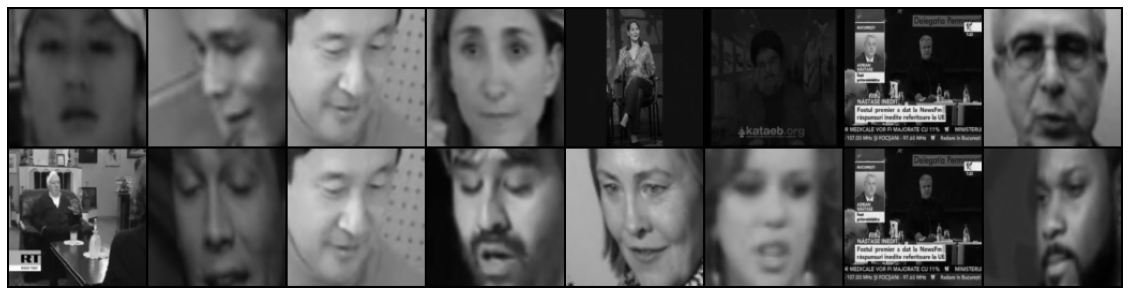

[1. 0. 0. 1. 0. 1. 0. 1.]


In [24]:
vis_dataloader = DataLoader(siamese_dataset_128x128_2,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8
)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=[20, 20])
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Siamese models

In [25]:
class SiameseNetwork128x128(nn.Module):
    def __init__(self):
        super(SiameseNetwork128x128, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =43264, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

In [27]:
class SiameseNetwork32x32(nn.Module):
    def __init__(self):
        super(SiameseNetwork32x32, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =256, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

Loss function

In [28]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

Train function

In [29]:
def train(device, siamese_model, epochs, optimizer, loss_function, train_dataloader, save):
    counter = []
    loss_history = [] 
    iteration_number= 0
    best_loss = 100
    for epoch in tqdm(range(0,epochs)):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data #data is 2 images and a label
            
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device) #push to gpu
            
            optimizer.zero_grad() #zero gradients for every batch
            
            output1,output2 = siamese_model(img0,img1) #pass 2 images in the network and obtain two outputs
            
            loss = loss_function(output1,output2,label) #compute loss for both outputs and the label
            
            loss.backward() #compute gradients
            
            optimizer.step() #adjust learning weights
            
            if i %len(train_dataloader) == 0 : #gather data and report progress
                print("Epoch number {}: Current loss {}".format(epoch, loss.item()))
                if loss.item() < best_loss:
                    torch.save(siamese_model.state_dict(), save)
                    best_loss = loss.item()
                    
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss.item())

    show_plot(counter,loss_history)

In [30]:
siamese_model128x128 = SiameseNetwork128x128().to(device)
siamese_model32x32 = SiameseNetwork32x32().to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 2.428574800491333


  7%|▋         | 1/15 [00:23<05:34, 23.92s/it]

Epoch number 1: Current loss 1.5028846263885498


 13%|█▎        | 2/15 [00:31<03:02, 14.07s/it]

Epoch number 2: Current loss 1.3609089851379395


 20%|██        | 3/15 [00:38<02:10, 10.86s/it]

Epoch number 3: Current loss 1.1123710870742798


 27%|██▋       | 4/15 [00:45<01:43,  9.38s/it]

Epoch number 4: Current loss 1.6106456518173218


 33%|███▎      | 5/15 [00:51<01:23,  8.34s/it]

Epoch number 5: Current loss 1.8391379117965698


 40%|████      | 6/15 [00:58<01:10,  7.83s/it]

Epoch number 6: Current loss 1.6600041389465332


 47%|████▋     | 7/15 [01:05<00:59,  7.46s/it]

Epoch number 7: Current loss 1.449742078781128


 53%|█████▎    | 8/15 [01:12<00:50,  7.28s/it]

Epoch number 8: Current loss 2.163445234298706


 60%|██████    | 9/15 [01:18<00:41,  6.98s/it]

Epoch number 9: Current loss 1.4710462093353271


 67%|██████▋   | 10/15 [01:24<00:33,  6.73s/it]

Epoch number 10: Current loss 1.5468714237213135


 73%|███████▎  | 11/15 [01:30<00:26,  6.56s/it]

Epoch number 11: Current loss 1.5937455892562866


 80%|████████  | 12/15 [01:36<00:19,  6.42s/it]

Epoch number 12: Current loss 1.8906190395355225


 87%|████████▋ | 13/15 [01:43<00:12,  6.46s/it]

Epoch number 13: Current loss 1.4531211853027344


 93%|█████████▎| 14/15 [01:50<00:06,  6.48s/it]

Epoch number 14: Current loss 1.5937447547912598


100%|██████████| 15/15 [01:56<00:00,  7.78s/it]


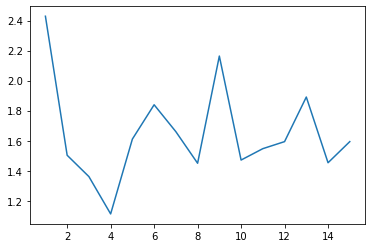

In [31]:
network128x128 = train(device, siamese_model128x128, 15, optim.Adam(siamese_model128x128.parameters()) , ContrastiveLoss(), train_dataloader_128x128_2, 'C:/Users/Tychon Bos/Documents/Siamese/Models/2Dlib/128x128.pth' )

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 1.7976309061050415


  7%|▋         | 1/15 [00:04<01:05,  4.65s/it]

Epoch number 1: Current loss 1.0782017707824707


 13%|█▎        | 2/15 [00:09<00:59,  4.58s/it]

Epoch number 2: Current loss 1.0195047855377197


 20%|██        | 3/15 [00:13<00:53,  4.49s/it]

Epoch number 3: Current loss 0.9707841277122498


 27%|██▋       | 4/15 [00:17<00:49,  4.46s/it]

Epoch number 4: Current loss 1.1310746669769287


 33%|███▎      | 5/15 [00:22<00:44,  4.42s/it]

Epoch number 5: Current loss 0.9469649195671082


 40%|████      | 6/15 [00:26<00:39,  4.42s/it]

Epoch number 6: Current loss 0.9976195096969604


 47%|████▋     | 7/15 [00:31<00:35,  4.44s/it]

Epoch number 7: Current loss 0.7959436178207397


 53%|█████▎    | 8/15 [00:35<00:30,  4.41s/it]

Epoch number 8: Current loss 1.0401191711425781


 60%|██████    | 9/15 [00:40<00:26,  4.42s/it]

Epoch number 9: Current loss 0.6652804613113403


 67%|██████▋   | 10/15 [00:44<00:22,  4.42s/it]

Epoch number 10: Current loss 1.0779738426208496


 73%|███████▎  | 11/15 [00:48<00:17,  4.42s/it]

Epoch number 11: Current loss 0.7786476612091064


 80%|████████  | 12/15 [00:53<00:13,  4.41s/it]

Epoch number 12: Current loss 0.9691828489303589


 87%|████████▋ | 13/15 [00:57<00:08,  4.43s/it]

Epoch number 13: Current loss 0.7587945461273193


 93%|█████████▎| 14/15 [01:02<00:04,  4.41s/it]

Epoch number 14: Current loss 0.8269379138946533


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


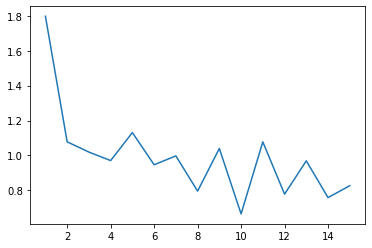

In [33]:
network32x32 = train(device, siamese_model32x32, 15, optim.Adam(siamese_model32x32.parameters()) , ContrastiveLoss(), train_dataloader_32x32_2, 'C:/Users/Tychon Bos/Documents/Siamese/Models/2Dlib/32x32.pth' )